# Importacion de librerias necesarias


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sbn
from sklearn import preprocessing

# Preprocesamiento y eleccion de variables

In [40]:
df=pd.read_csv('/content/Mall_Customers.csv')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


Datos estadisticos del DataFrame


In [41]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Matriz de coorelacion

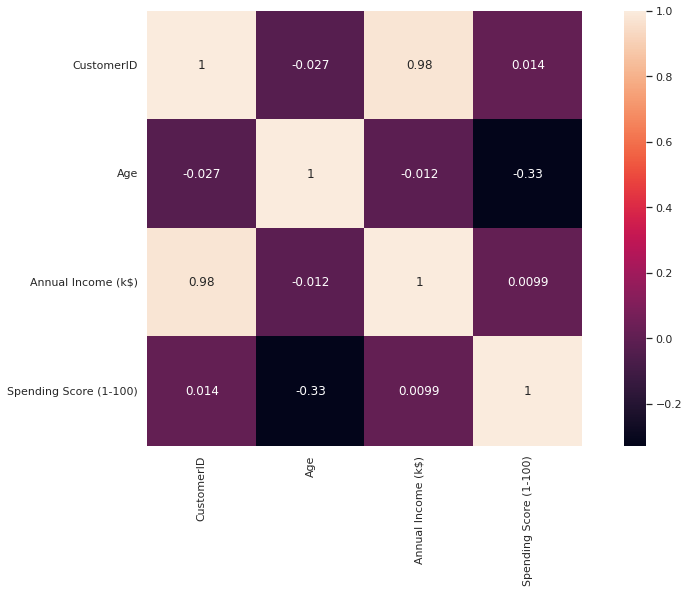

In [42]:
sbn.set(rc = {'figure.figsize':(15,8)})
sbn.heatmap(df.corr(), square=True, annot=True)

eliminamos el id del cliente

In [43]:
df = df.drop(['CustomerID', 'Gender'], axis = 1)

In [44]:
df

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


# Escalamiento y detección de outliers

In [45]:
X = df.iloc[:,:].values
X

array([[ 19,  15,  39],
       [ 21,  15,  81],
       [ 20,  16,   6],
       [ 23,  16,  77],
       [ 31,  17,  40],
       [ 22,  17,  76],
       [ 35,  18,   6],
       [ 23,  18,  94],
       [ 64,  19,   3],
       [ 30,  19,  72],
       [ 67,  19,  14],
       [ 35,  19,  99],
       [ 58,  20,  15],
       [ 24,  20,  77],
       [ 37,  20,  13],
       [ 22,  20,  79],
       [ 35,  21,  35],
       [ 20,  21,  66],
       [ 52,  23,  29],
       [ 35,  23,  98],
       [ 35,  24,  35],
       [ 25,  24,  73],
       [ 46,  25,   5],
       [ 31,  25,  73],
       [ 54,  28,  14],
       [ 29,  28,  82],
       [ 45,  28,  32],
       [ 35,  28,  61],
       [ 40,  29,  31],
       [ 23,  29,  87],
       [ 60,  30,   4],
       [ 21,  30,  73],
       [ 53,  33,   4],
       [ 18,  33,  92],
       [ 49,  33,  14],
       [ 21,  33,  81],
       [ 42,  34,  17],
       [ 30,  34,  73],
       [ 36,  37,  26],
       [ 20,  37,  75],
       [ 65,  38,  35],
       [ 24,  38

In [46]:
N = X.shape[0] 
K = 2 

SSE = []
for i in range(0, N):
  X_sin_i = np.delete(X, i, axis=0) 
  kmeans = KMeans(n_clusters=K, n_init=10, random_state=100).fit(X_sin_i)
  SSE.append(kmeans.inertia_)

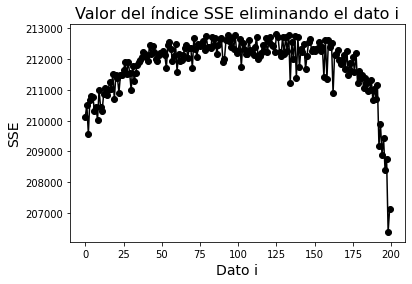

In [10]:
plt.plot(np.arange(0, N), SSE, "ko-")
plt.title("Valor del índice SSE eliminando el dato i", fontsize=16)
plt.xlabel("Dato i", fontsize=14)
plt.ylabel("SSE", fontsize=14)
plt.show()

Detectar y eliminar outliers
Almacenaremos el índice SSE de cada una de las ejecuciones en un vector. Esa
información se puede obtener con la variable inertia_ del modelo

In [48]:
sigma = np.std(SSE) 
mu = np.mean(SSE) 
umbral = 2 
outliers = []
for i in range(0, N):
  if np.abs(SSE[i]-mu) > umbral*sigma:
    outliers.append(i)
print(outliers)

[2, 192, 193, 194, 195, 196, 197, 198, 199]


In [49]:
X_new = np.delete(X, outliers, axis=0)
X_new.shape

(191, 3)

# Optimizacion de la funcion BIC

In [50]:
def BIC(K, grupos, X):
  """
  K: Número de grupos (clusters)
  grupos: Vector que contiene los grupos de los datos
  X: Matriz de datos
  """
  N = X.shape[0] # Número de datos
  P = X.shape[1] # Número de variables
  xi = np.zeros((1,K)) # Vector xi

  # Calculamos el sumario de xi en la fórmula
  for k in range(0, K):
    suma = 0
    for j in range(0, P):
      sigma = np.square(np.std(X[:, j]))
      sigma_j = np.square(np.std(X[grupos==k, j]))
      suma += 0.5*np.log(sigma + sigma_j)

    n_k = sum(grupos==k) # Número de elementos en el grupo k
    xi[0, k] = -n_k*suma

  bic = -2*np.sum(xi) + 2*K*P*np.log(N)
  return bic

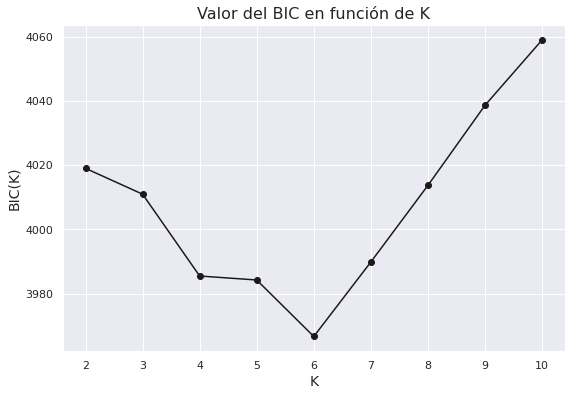

In [51]:
## Calculo del BIC
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Kmax = 10
BIC_array = []
for k in range(2, Kmax+1):
  kmeans = KMeans(n_clusters=k, n_init=15, random_state=100)
  grupos = kmeans.fit_predict(X)
  BIC_array.append(BIC(k, grupos, X))

# Dibujamos el BIC obtenido para cada valor de k
plt.figure(figsize=(9, 6))
plt.plot(np.arange(2, Kmax+1), BIC_array, "ko-")
plt.title("Valor del BIC en función de K", fontsize=16)
plt.xlabel("K", fontsize=14)
plt.ylabel("BIC(K)", fontsize=14)
plt.show()

# Ejecución de análisis cluster con un valor de k concreto (número de grupos), por ejemplo 4, y determinar el número de réplicas (n_init) del algoritmo que conduce a que la repetición de dicho algoritmo genere la misma solución.

In [52]:
kmeans = KMeans(n_clusters=4, n_init=30, random_state=100)
pred = kmeans.fit_predict(X_new)
centroides = kmeans.cluster_centers_

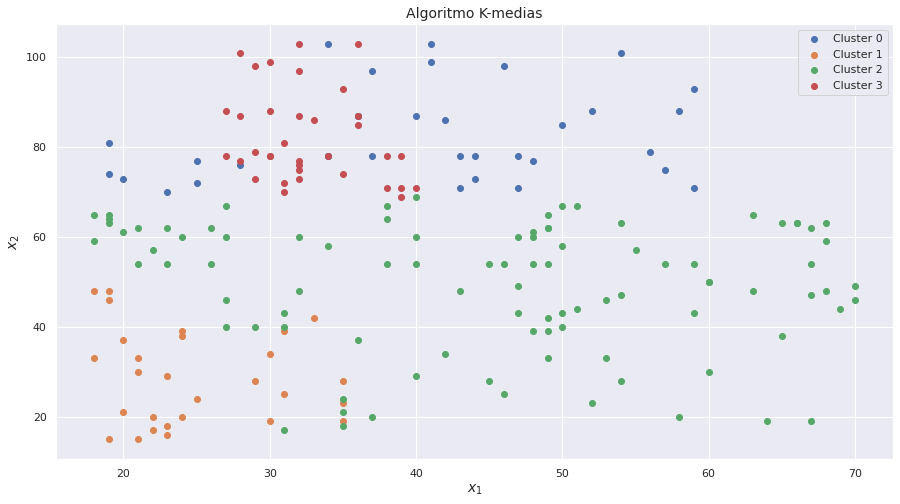

In [53]:
for k in range(0, 4):
  plt.scatter(X_new[pred==k, 0], X_new[pred==k, 1], label="Cluster {}".format(k)) 

plt.title("Algoritmo K-medias", fontsize=14)
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14)
plt.legend()
plt.show()

#Mostrar para el análisis anterior una tabla con los siguientes datos: número de grupo, cantidad de observaciones de ese grupo y el centroide que representa a ese grupo(valor de cada variable)

In [54]:
df.columns

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [56]:
centroides

array([[40.52941176, 82.64705882, 18.76470588],
       [24.82142857, 28.71428571, 74.25      ],
       [45.15957447, 49.05319149, 43.0212766 ],
       [32.57142857, 82.25714286, 82.17142857]])

In [58]:
tabla = pd.DataFrame(columns = ['Grupos','Numero Observaciones', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
grupos = np.bincount(pred)

for k in range(4):
  tabla.loc[k, 'Grupos'] = k
  tabla.loc[k, "Numero Observaciones"] = grupos[k]
  tabla.loc[k,'Age'] = centroides[k,0]
  tabla.loc[k,'Annual Income (k$)'] = centroides[k,1]
  tabla.loc[k,'Spending Score (1-100)'] = centroides[k,2]  
tabla


,Grupos,Numero Observaciones,Age,Annual Income (k$),Spending Score (1-100)
0,0,34,40.529412,82.647059,18.764706
1,1,28,24.821429,28.714286,74.25
2,2,94,45.159574,49.053191,43.021277
3,3,35,32.571429,82.257143,82.171429
